In [1]:
import os
import sys
import pandas as pd
import yfinance as yf
import numpy as np
sys.path.append(os.path.join('Momentum_additional_files'))
import matplotlib.dates as mdates

from config import *
from helper import *
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

price_data_df = pd.read_csv(DATA_ADJ_CLOSE_LOC)

price_data_df = collecting_data(START_DATE, END_DATE, DATA_ADJ_CLOSE_LOC)
rel3, rel12, rel_lag = get_relative(price_data_df)
price_data_df.index  = price_data_df['Date']

In [7]:
def momentum_strategy(price_data_df, relative_df):
    
    open_positions = {}
    total_gained_valued = 0
    
    
    # Loop over each month in the data
    for ii, date in enumerate(relative_df.index, 1):
    
        if ii <= len(relative_df) - HOLDING_PERIOD_MONTHS: 
            # Get the returns for the past formation period
            past_returns = relative_df.loc[date]
            
            # Rank stocks based on past returns
            ranked_stocks = past_returns.rank(ascending=True)
        
            # Define deciles
            losers_stocks = ranked_stocks[ranked_stocks <= ranked_stocks.quantile(1/TOP_DECILE)].index.values.tolist()
            winners_stocks = ranked_stocks[ranked_stocks >= ranked_stocks.quantile(1 - (1/TOP_DECILE))].index.values.tolist()
            
            winners_stocks_value = price_data_df.loc[date][winners_stocks].sum()
            losers_stocks_value = price_data_df.loc[date][losers_stocks].sum()

            balance_losers =  winners_stocks_value / losers_stocks_value
                
            open_positions[ii] = {'date':date,
                                  'w_stocks': winners_stocks, 
                                  'l_stocks': losers_stocks,
                                  'balance_losers':balance_losers,
                                  'ini_stock_val': 2 * winners_stocks_value}

        if HOLDING_PERIOD_MONTHS < ii:    
            prev_loc = ii - HOLDING_PERIOD_MONTHS
            winners_stocks = open_positions[prev_loc]['w_stocks']
            losers_stocks = open_positions[prev_loc]['l_stocks']
            balance_losers = open_positions[prev_loc]['balance_losers']
    
            winners_stocks_value = price_data_df.loc[date][winners_stocks].sum()
            losers_stocks_value = price_data_df.loc[date,][losers_stocks].sum()
    
            gained_valued = winners_stocks_value - (losers_stocks_value * balance_losers)
            base_gain = open_positions[prev_loc]['ini_stock_val']
            
            open_positions[prev_loc]['rel_gained'] =  (gained_valued +  base_gain) / base_gain
            open_positions[prev_loc]['gained_valued'] = gained_valued
    
            # print(prev_loc,base_gain,gained_valued,(gained_valued +  base_gain) / base_gain)
            total_gained_valued += gained_valued
            # print(date, total_gained_valued)
    
    return open_positions, total_gained_valued

open_positions, total_gained_valued = momentum_strategy(price_data_df, rel12)


Average gain:1456.4633785258266. The p-value: 5.283573548111126e-42


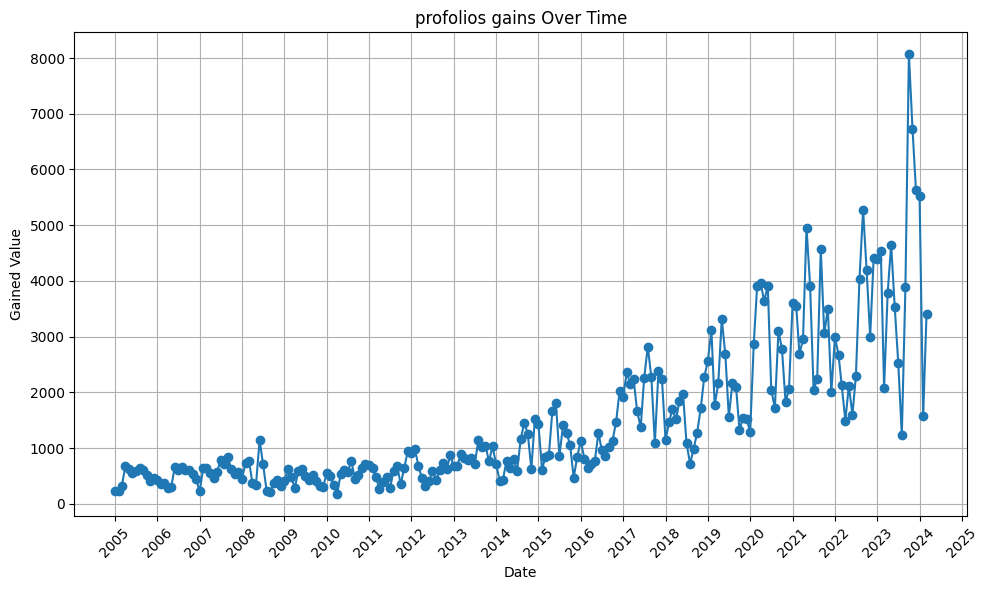

In [8]:
open_positions, total_gained_valued = momentum_strategy(price_data_df, rel12)
avg_gain, p_value = calc_one_sided_test(open_positions)  
print(f'Average gain:{avg_gain}. The p-value: {p_value}')
plot_profolios(open_positions)   

In [68]:

def calculate_metrics(strategy_returns, sp500_returns, risk_free_rate):
    # Annualized Return (Assume monthly returns are used)
    annualized_return = np.prod(1 + strategy_returns) ** (12 / len(strategy_returns)) - 1
    
    # Volatility (Annualized)
    volatility = strategy_returns.std() * np.sqrt(12)  # 12 months in a year
    
    # Sharpe Ratio 
    sharpe_ratio = (annualized_return - risk_free_rate['Difference'].mean()) / volatility
    
    # Max Drawdown
    cumulative_returns = (1 + strategy_returns).cumprod()
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    
    # Value at Risk (VaR) at 1% and 5%
    VaR_1 = np.percentile(strategy_returns, 1)
    VaR_5 = np.percentile(strategy_returns, 5)
    
    # Alpha against S&P 500 (CAPM)
    alpha = ((1 + annualized_return) / (1 + sp500_returns.mean()) - 1) * 12

    return {
        'Annualized Return': annualized_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'VaR 1%': VaR_1,
        'VaR 5%': VaR_5,
        'Alpha': alpha}

In [84]:
b_date, e_date = calc_profolios_dates(START_DATE, END_DATE, FORMATION_PERIOD_MONTHS, HOLDING_PERIOD_MONTHS)
sp500 = yf.download('^GSPC', start=b_date, end=e_date, interval='1mo')[STOCK_TIME]
risk_free_rate = get_risk_free_rate(START_DATE, END_DATE)
sp500_returns = sp500.pct_change().dropna()

strategy_returns =  pd.Series({v['date']: v['rel_gained'] for v in open_positions.values()}) - 1
metrics = calculate_metrics(strategy_returns, sp500_returns, risk_free_rate)

for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Annualized Return: 2.3620
Volatility: 0.1133
Sharpe Ratio: 21.2045
Max Drawdown: 0.0000
VaR 1%: 0.0515
VaR 5%: 0.0648
Alpha: 28.0427



/tmp/ipykernel_34741/635937231.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_diff = data.groupby('Year').apply(calculate_yearly_diff)


In [77]:
strategy_returns =  pd.Series({v['date']: v['gained_valued'] for v in open_positions.values()}) - 1
strategy_returns

2005-01-01 00:00:00+00:00     232.941286
2005-02-01 00:00:00+00:00     233.122118
2005-03-01 00:00:00+00:00     327.844910
2005-04-01 00:00:00+00:00     682.424802
2005-05-01 00:00:00+00:00     629.111967
                                ...     
2023-11-01 00:00:00+00:00    6732.371142
2023-12-01 00:00:00+00:00    5624.660554
2024-01-01 00:00:00+00:00    5522.273914
2024-02-01 00:00:00+00:00    1568.673593
2024-03-01 00:00:00+00:00    3406.418715
Length: 231, dtype: float64

In [80]:

strategy_returns[strategy_returns>0]

2005-01-01 00:00:00+00:00     232.941286
2005-02-01 00:00:00+00:00     233.122118
2005-03-01 00:00:00+00:00     327.844910
2005-04-01 00:00:00+00:00     682.424802
2005-05-01 00:00:00+00:00     629.111967
                                ...     
2023-11-01 00:00:00+00:00    6732.371142
2023-12-01 00:00:00+00:00    5624.660554
2024-01-01 00:00:00+00:00    5522.273914
2024-02-01 00:00:00+00:00    1568.673593
2024-03-01 00:00:00+00:00    3406.418715
Length: 231, dtype: float64

In [76]:
import pandas as pd

# Assume you have a pandas Series 'strategy_returns' with your monthly returns

# Step 1: Calculate cumulative returns
cumulative_returns = (1 + strategy_returns).cumprod()

# Step 2: Calculate running maximum
running_max = cumulative_returns.cummax()

# Step 3: Calculate drawdown
drawdown = (cumulative_returns - running_max) / running_max

# Step 4: Find Maximum Drawdown (MDD)
max_drawdown = drawdown.min()

print("Maximum Drawdown (MDD):", max_drawdown)


Maximum Drawdown (MDD): 0.0


In [70]:
# Annualized Return (Assume monthly returns are used)
annualized_return = np.prod(1 + strategy_returns) ** (12 / len(strategy_returns)) - 1

# Volatility (Annualized)
volatility = strategy_returns.std() * np.sqrt(12)  # 12 months in a year

# Sharpe Ratio 
sharpe_ratio = (annualized_return - risk_free_rate.mean()) / volatility

# Max Drawdown
cumulative_returns = (1 + strategy_returns).cumprod()
max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()

# Value at Risk (VaR) at 1% and 5%
VaR_1 = np.percentile(strategy_returns, 1)
VaR_5 = np.percentile(strategy_returns, 5)

# Alpha against S&P 500 (CAPM)
alpha = ((1 + annualized_return) / (1 + sp500_returns.mean()) - 1) * 12


# Plot stocks prices

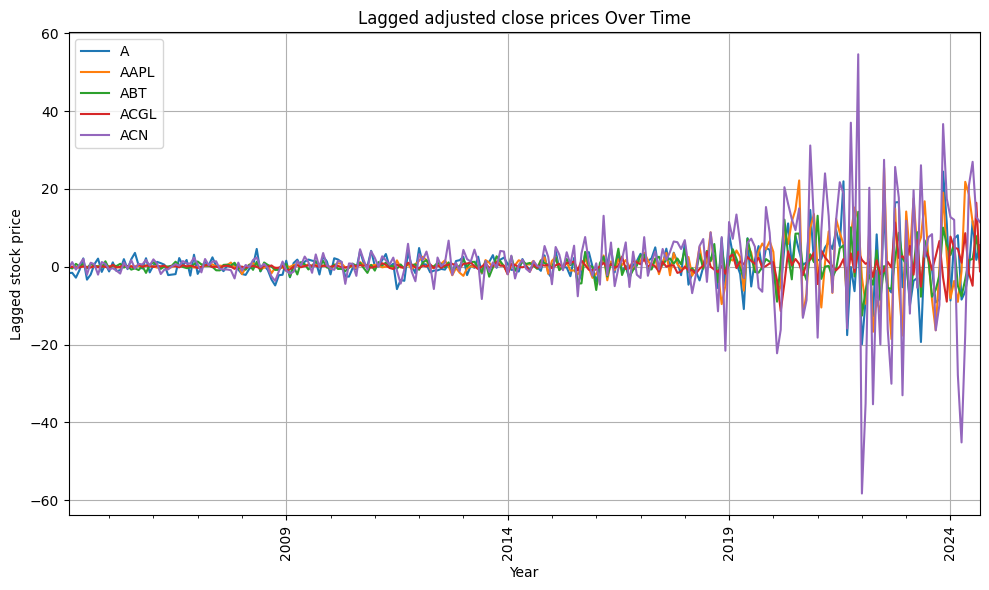

In [5]:
selected_lag_df = rel_lag[['Date','A','AAPL','ABT','ACGL','ACN']].iloc[1:]

selected_lag_df['Date'] = pd.to_datetime(selected_lag_df['Date']).dt.tz_localize(None)
selected_lag_df.set_index('Date')[['A','AAPL','ABT','ACGL','ACN']].plot(figsize=(10, 6))

plt.title('Lagged adjusted close prices Over Time')
plt.xlabel('Year')
plt.ylabel('Lagged stock price')

plt.xticks(rotation=90)
plt.grid()
plt.tight_layout() 
plt.show()

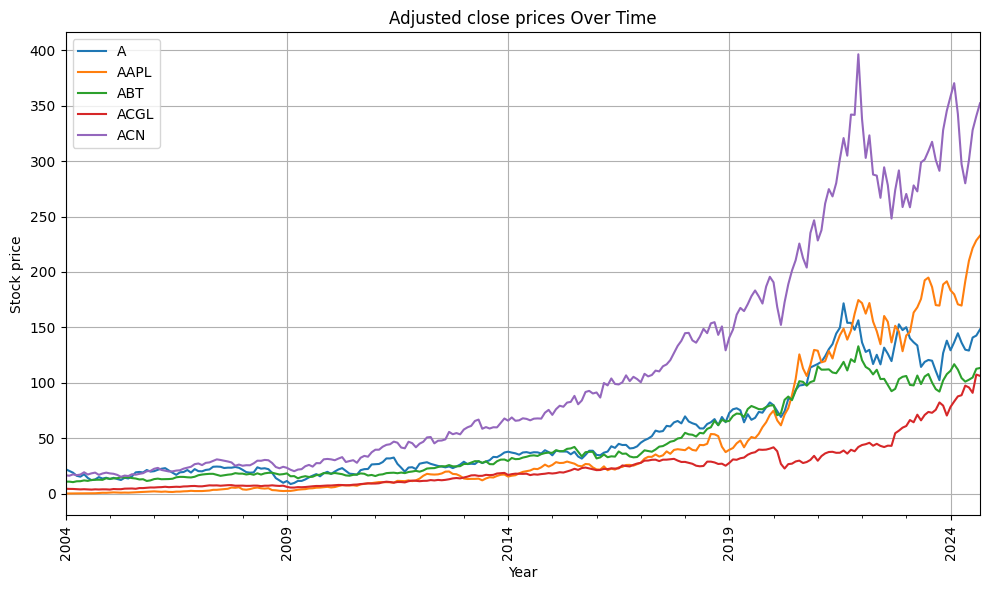

In [8]:
import matplotlib.dates as mdates

selected_df = price_data_df[['Date','A','AAPL','ABT','ACGL','ACN']].iloc[1:]
selected_df['Date'] = pd.to_datetime(selected_df['Date']).dt.tz_localize(None)
# selected_df['Year'] = selected_df['Date'].apply(lambda x: x.year)

selected_df.set_index('Date')[['A','AAPL','ABT','ACGL','ACN']].plot(figsize=(10, 6))

plt.title('Adjusted close prices Over Time')
plt.xlabel('Year')
plt.ylabel('Stock price')

plt.xticks(rotation=90)
plt.grid()
plt.tight_layout() 
plt.show()